 # 单因子分析：质量因子 (Quality Factor)

**目标**: 本 Notebook 旨在演示如何在一个文件中完成因子的定义、计算、回测与分析。

**核心思想**: 我们将遵循《因子投资：方法与实践》中定义的标准因子测试流程。该流程的核心是：
1.  **数据准备**: 加载并清洗干净的股票行情与财务数据。
2.  **因子定义与计算**: 在 Notebook 中直接定义因子计算逻辑，并计算我们感兴趣的因子——基于净资产收益率（ROE）的质量因子。
3.  **分组回测**: 在每个时间点，根据因子值将所有股票排序并分为N组（例如5组），然后观察每组的未来收益表现。
4.  **业绩分析**: 通过多空组合（做多因子值最高组，做空因子值最低组）的净值曲线、年化收益、夏普比率等指标来评估因子的有效性。

In [1]:
# -- 步骤 0: 导入必要的库并设置项目路径 --
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# 将项目根目录添加到Python的模块搜索路径中
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
# 从项目中导入我们需要的模块
from data_manager.loader import load_and_clean_data
from backtest_engine.engine import BacktestEngine
from backtest_engine.performance import PerformanceAnalyzer

print(f"项目根目录已设置为: {project_root}")

项目根目录已设置为: /Users/nachuanchen/Documents/Undergrad_Resources/投资学/Factor_strategy_platform


### 步骤 1: 加载并清洗数据
我们首先调用 `data_manager` 模块中的 `load_and_clean_data` 函数来获取一个干净、对齐的 `master_data` 数据框。这是所有因子计算的基础。

In [2]:
DATA_DIR_PATH = os.path.join(project_root, "data_manager", "DemoData")

master_df, index_df = load_and_clean_data(DATA_DIR_PATH)

if master_df is not None:
    print("\n主数据加载成功，预览:")
    display(master_df.head())

开始执行数据加载与清洗任务...

[步骤 1/4] 正在加载CSV文件...
所有CSV文件加载成功！

[步骤 2/4] 正在进行数据预处理...
 -> 行情数据处理完成，已计算后复权价。
 -> 财务数据处理完成。
 -> 指数数据处理完成。

[步骤 3/4] 正在合并行情与财务数据...
行情与财务数据合并成功！

[步骤 4/4] 正在进行最终清洗...
 -> 已对财务数据进行缩尾处理。

数据加载与清洗任务完成！

主数据加载成功，预览:


open   high    low  close   adjfactor       volume  \
date       stock_code                                                        
2024-01-02 000001.SZ    9.39   9.42   9.21   9.21   71.643514  115836645.0   
           000002.SZ   10.44  10.48  10.15  10.15  181.703787   81110629.0   
           000004.SZ   16.10  16.44  16.05  16.14    4.063862    2886700.0   
           000005.SZ    1.08   1.12   1.08   1.12    9.267603    6302800.0   
           000006.SZ    4.58   4.60   4.45   4.47   39.739675   26194719.0   

                                amt   mkt_cap_ard      turn    adj_close  \
date       stock_code                                                      
2024-01-02 000001.SZ   1.075742e+09  1.787285e+11  0.596925   659.836764   
           000002.SZ   8.307655e+08  1.210967e+11  0.834735  1844.293438   
           000004.SZ   4.679115e+07  2.136618e+09  2.285805    65.590733   
           000005.SZ   6.967071e+06  1.185561e+09  0.595758    10.379715   
           000006.SZ   1.176632e+08  6.034478e+09  1.940368   177.636347   

                          adj_open report_date  ROE_AVG     ROA2  CATOASSETS  \
date       stock_code                                                          
2024-01-02 000001.SZ    672.732596  2023-12-31  10.2436      NaN         NaN   
           000002.SZ   1896.987536  2023-12-31   4.9294   1.9955     76.4368   
           000004.SZ     65.428178  2023-12-31 -57.2888 -35.8637     78.4352   
           000005.SZ     10.009011  2023-12-31 -17.9094  -8.1847     56.6478   
           000006.SZ    182.007711  2023-12-31 -10.7927  -1.3205     84.0593   

                       ASSETSTOEQUITY  CURRENT  
date       stock_code                           
2024-01-02 000001.SZ          11.8289      NaN  
           000002.SZ           3.7347   1.3997  
           000004.SZ           2.1326   1.6630  
           000005.SZ           2.1801   1.6617  
           000006.SZ           3.4829   1.7350

### 步骤 2: 定义并计算质量因子
我们将因子计算的逻辑直接定义在本单元格中，然后进行计算。

**理论依据**: 根据《因子投资：方法与实践》第 3.6 节，盈利因子是质量因子的重要组成部分，其理论基础扎实，源于股利贴现模型和实体投资经济学理论 。研究表明，ROE 代表的盈利能力与股票的未来收益呈显著正相关 。因此，我们将直接使用 `ROE_AVG` 作为质量因子的代理变量。

In [3]:
class QualityFactor:
    """
    计算质量因子类。
    核心逻辑基于《因子投资：方法与实践》对盈利因子的定义。
    """

    def __init__(self, master_data):
        """
        初始化质量因子计算。

        Args:
            master_data (pd.DataFrame): 经过loader.py清洗和合并后的主数据框。
                                        必须包含 'ROE_AVG' (净资产收益率) 字段。
        """
        if 'ROE_AVG' not in master_data.columns:
            raise ValueError("错误: 输入的数据中缺少 'ROE_AVG' (净资产收益率) 字段。")

        self.master_data = master_data
        self.factor_name = 'roe_factor'

    def calculate_factor(self):
        """
        计算 ROE 质量因子。
        根据《因子投资：方法与实践》第 3.6 节，盈利能力强的公司有更高的预期收益。
        我们直接使用 ROE_AVG 作为盈利能力的代理变量。
        """
        print(f"\n[因子计算] 正在计算 {self.factor_name} (质量因子)...")

        # 直接选取 ROE_AVG 作为因子值
        factor_data = self.master_data[['ROE_AVG']].copy()
        factor_data.rename(columns={'ROE_AVG': self.factor_name}, inplace=True)

        factor_data.dropna(inplace=True)

        print(f"{self.factor_name} 计算完成！")

        return factor_data

# -- 开始计算 --
quality_calculator = QualityFactor(master_df)
quality_factor_df = quality_calculator.calculate_factor()

print("\n质量因子计算完成，预览:")
display(quality_factor_df.head())


[因子计算] 正在计算 roe_factor (质量因子)...
roe_factor 计算完成！

质量因子计算完成，预览:


roe_factor
date       stock_code            
2024-01-02 000001.SZ      10.2436
           000002.SZ       4.9294
           000004.SZ     -57.2888
           000005.SZ     -17.9094
           000006.SZ     -10.7927

### 步骤 3: 运行分组回测
接下来，我们将 `master_df` 和计算出的 `quality_factor_df` 传入 `BacktestEngine`。在这里，我们需要做出一个关键的假设：
- `long_direction`: 这个参数决定了我们是做多因子值大的一组还是小的一组。
  - `'high'`: 做多因子值最高的组 (Group 5)。
  - `'low'`: 做多因子值最低的组 (Group 1)。

**假设**: 根据《因子投资：方法与实践》的理论，盈利能力越强的公司，未来预期收益越高。因此，我们假设做多 ROE 最高的股票组合能获得超额收益，将 `long_direction` 设置为 `'high'`。

In [4]:
backtest = BacktestEngine(
    master_data=master_df, 
    factor_data=quality_factor_df, 
    n_groups=5, 
    long_direction='high' # 假设做多高 ROE 组合
)

portfolio_returns = backtest.run()

print("\n回测完成，各投资组合每日收益率预览：")
display(portfolio_returns.head())

Backtest Engine initialized. Long direction set to: 'high'

[Backtest] Starting vectorized backtest...
 -> Step 1: Data alignment and merge complete.
 -> Step 2: Stocks grouped into 5 portfolios based on 'roe_factor'.
 -> Step 3: Daily group returns calculated.
 -> Strategy: Long Group_5, Short Group_1
 -> Step 4: Long-Short portfolio constructed correctly.
[Backtest] Backtest execution finished!

回测完成，各投资组合每日收益率预览：


,Group_1,Group_2,Group_3,Group_4,Group_5,Long_Short,Long_Only
date,,,,,,,
2024-01-02,0.005871,0.003958,0.004991,0.003910,0.003092,-0.002779,0.003092
2024-01-03,0.003257,-0.001773,-0.001450,-0.001739,-0.001718,-0.004975,-0.001718
2024-01-04,-0.014909,-0.014723,-0.008424,-0.010763,-0.007304,0.007605,-0.007304
2024-01-05,-0.018594,-0.020147,-0.017985,-0.019690,-0.013052,0.005542,-0.013052
2024-01-08,0.011050,0.006803,0.003476,0.006945,0.007009,-0.004041,0.007009


### 步骤 4: 性能分析与可视化
最后，我们使用 `PerformanceAnalyzer` 对回测结果进行全面的分析。它会自动计算年化收益、夏普比率、最大回撤等关键指标，并绘制净值曲线图、分组收益图和IC分析图等。

Performance Analyzer initialized.

[Performance Analysis] Calculating portfolio performance metrics...
Portfolio Performance Metrics:
            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Group_1               -0.6149                 0.3766       -1.6326   
Group_2               -0.4679                 0.3531       -1.3252   
Group_3               -0.2610                 0.3008       -0.8677   
Group_4               -0.2192                 0.2771       -0.7909   
Group_5                0.1931                 0.2233        0.8648   
Long_Short             1.8393                 0.2745        6.7013   
Long_Only              0.1931                 0.2233        0.8648   

            Max Drawdown  Information Ratio (vs Benchmark)  
Group_1          -0.3649                               NaN  
Group_2          -0.2717                               NaN  
Group_3          -0.1973                               NaN  
Group_4          -0.1833                               NaN  


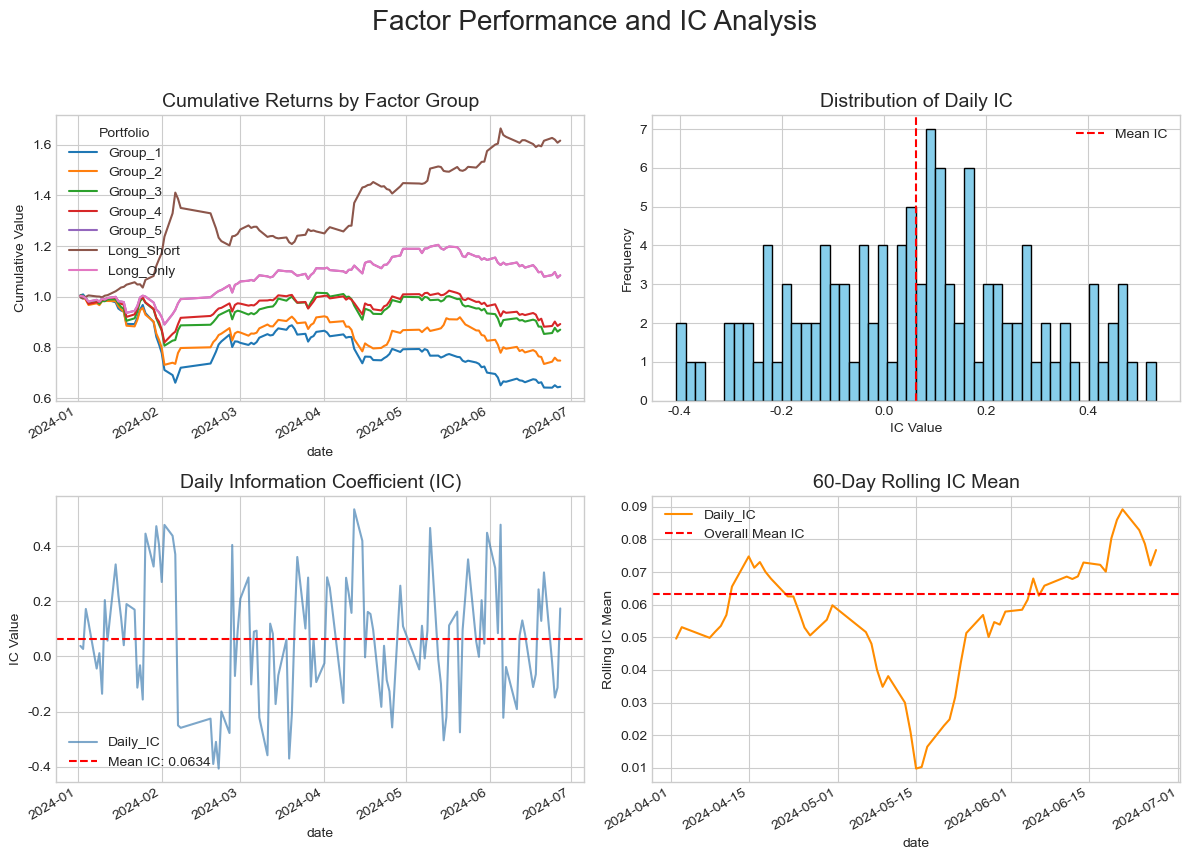

Plotting complete.


In [5]:
if portfolio_returns is not None:
    # 将所有需要的数据传入分析器
    analyzer = PerformanceAnalyzer(portfolio_returns, quality_factor_df, master_df)
    
    # 1. 计算各项性能指标
    analyzer.calculate_metrics()
    
    # 2. 绘制图表
    analyzer.plot_results()

### 结论解读

根据输出的图表和指标，我们可以对质量因子在回测期间的表现做出判断：
- **净值曲线 (`Cumulative Returns`)**: `Long_Short`（多空对冲）组合的净值是否长期向上？如果净值曲线稳定上升，说明高ROE公司确实持续跑赢低ROE公司，因子有效。
- **分组收益 (`Group Cumulative Returns`)**: 从Group 1到Group 5的最终净值是否呈现单调递增的趋势？根据我们的假设，我们期望看到Group 5（高ROE组）的收益显著高于其他组，特别是Group 1（低ROE组）。
- **IC分析 (`Information Coefficient Analysis`)**: IC均值是否显著为正？这直接衡量了ROE因子对下一期收益的预测能力。

通过这个流程，你可以检验盈利能力是否在你的模拟盘时间段内是一个有效的选股因子。